# **Step2_AI 강사 Agent v2.0**

## **0. 미션**

### **미션③ : 모듈 고도화1**
다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.

* 입력 프롬프트 추가 : 강의 목소리, 톤 조절, 강의 스타일 지침
* 정보 분해 : 여러 슬라이드를 저장하고 관리하기 위한 폴더 준비, 불필요한 정보 제거, 제목 추출
* 페이지별 내용 생성 : 슬라이드 내 정보 뿐만 아니라 부연 설명을 위한 검색 기능 추가
* 강의 스크립트 생성 : 전체 강의 내용을 참조하여 강의 흐름을 구상하고,
                                   현재 페이지 강의 스크립트 작성
* 내용 검토 : 페이지 내용과 강의 스크립트 비교, 강의 스크립트 흐름 적절한지 검토




### **미션④ : AI 강사 Agent 완성**
* 모듈 고도화2(다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.)
    * 음성 변환 : 강의 목소리, 톤 조절 음성 변환
    * 영상 제작 :
        * 각 페이지 : 음성과 슬라이드 스냅샷 이미지 합성하여 영상 제작하기
        * 전체 강의 영상 : 각 슬라이드 강의를 전체 슬라이드 강의 영상으로 합치기
* 웹 화면 연결(gradio)
    * 음성 변환 : 강의 목소리, 톤 조절 프롬프트 기반 음성 변환
* 전체 Agent 그래프 구축
    * 전체를 Agent 그래프로 엮기


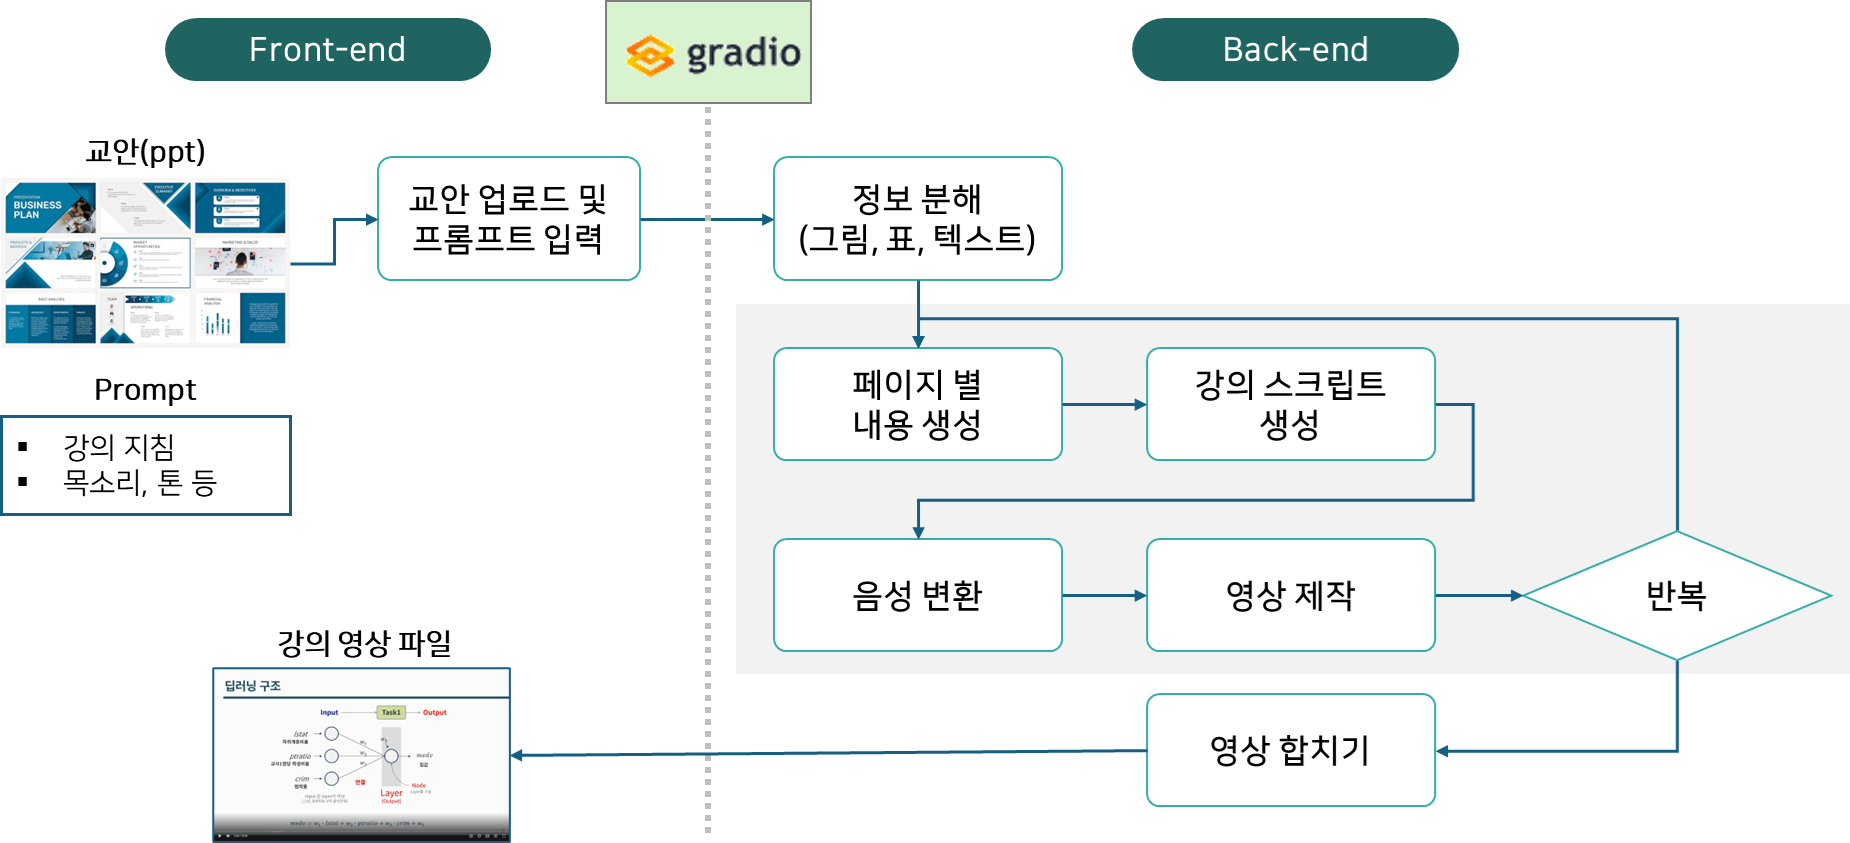

## **1. 환경준비**

### (1) 구글 드라이브

* 구글 드라이브 폴더 생성
    * 새 폴더(project_multi_modal)를 생성하고
    * 제공 받은 파일을 업로드

* 구글 드라이브 연결

In [207]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (2) 한글 폰트 준비
* 한글 폰트 설치 및 설정 코드
* 영상 제작 등 한글 사용시 필요

In [208]:
!apt-get -y install ffmpeg libreoffice poppler-utils poppler-data locales \
                   fonts-noto-cjk fonts-noto-cjk-extra fonts-nanum fonts-unfonts-core
!sed -i 's/^# *ko_KR.UTF-8 UTF-8/ko_KR.UTF-8 UTF-8/' /etc/locale.gen
!locale-gen ko_KR.UTF-8
!update-locale LANG=ko_KR.UTF-8
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
fonts-noto-cjk-extra is already the newest version (1:20220127+repack1-1).
poppler-data is already the newest version (0.4.11-1).
fonts-nanum is already the newest version (20200506-1).
fonts-unfonts-core is already the newest version (1:1.0.2-080608-16).
locales is already the newest version (2.35-0ubuntu3.11).
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libreoffice is already the newest version (1:7.3.7-0ubuntu0.22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Generating locales (this might take a while)...
  ko_KR.UTF-8... done
Generation complete.
/usr/share/fonts: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching,

In [209]:
%%bash
mkdir -p ~/.config/fontconfig
cat > ~/.config/fontconfig/fonts.conf <<'EOF'
<?xml version="1.0"?>
<!DOCTYPE fontconfig SYSTEM "fonts.dtd">
<fontconfig>

  <!-- ▷ 한국어 텍스트엔 Noto Sans CJK KR을 우선 사용 -->
  <match target="pattern">
    <test name="lang" compare="eq"><string>ko</string></test>
    <edit name="family" mode="prepend" binding="strong">
      <string>Noto Sans CJK KR</string>
    </edit>
  </match>

  <!-- ▷ 일반 가족명에도 기본 대체 추가 -->
  <alias><family>sans-serif</family><prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>serif</family><prefer><family>Noto Serif CJK KR</family></prefer></alias>
  <alias><family>monospace</family><prefer><family>Noto Sans Mono CJK KR</family></prefer></alias>

  <!-- ▷ Windows/macOS/웹에서 흔한 한글 폰트들을 Noto로 매핑 -->
  <alias><family>Malgun Gothic</family>        <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>맑은 고딕</family>             <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Apple SD Gothic Neo</family>  <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>AppleGothic</family>          <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Pretendard</family>           <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Pretendard Variable</family>  <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>NanumSquare</family>          <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Spoqa Han Sans</family>       <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>KoPub</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Gulim</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Dotum</family>                <prefer><family>Noto Sans CJK KR</family></prefer></alias>
  <alias><family>Batang</family>               <prefer><family>Noto Serif CJK KR</family></prefer></alias>
</fontconfig>
EOF
fc-cache -fv


/usr/share/fonts: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype/linux-libertine: caching, new cache contents: 13 fonts, 0 dirs
/usr/share/fonts/opentype/noto: caching, new cache contents: 80 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 11 dirs
/usr/share/fonts/truetype/crosextra: caching, new cache contents: 8 fonts, 0 dirs
/usr/sh

### (3) 라이브러리

* 필요한 라이브러리 설치

In [210]:
!apt-get -y install ffmpeg libreoffice poppler-utils
!pip install python-pptx pillow langgraph google-search-results gradio -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libreoffice is already the newest version (1:7.3.7-0ubuntu0.22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


* 라이브러리 로딩

In [211]:
import os, re, textwrap, subprocess, json, base64, mimetypes, shlex
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Optional, TypedDict, Any
from PIL import Image, ImageDraw
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE
from openai import OpenAI
from google.colab import files
from IPython.display import Audio, display, Video

from serpapi import GoogleSearch

### (4) OpenAI API Key 확인
* 구글드라이브에 생성한 폴더 'project_multi_modal'에서
* api_key.txt 파일 안에 각자 발급 받은 키를 저장합니다.
    * **openai api key**
    * **SERPAPI_API_KEY**

In [212]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = "/content/drive/MyDrive/langchain/"
# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

In [213]:
print(os.environ['OPENAI_API_KEY'][:30])
print(os.environ['SERPAPI_API_KEY'][:30])

sk-proj--g_9dmXqyvfK-dEpaTsQXe
de1c6d5a22af311af4f7baffc6d4a5


### (5) 유용한 함수들 제공
* 다음은 프로젝트를 수행하는데 유용한 함수들입니다.
* 이 함수들의 내용을 확인하고 필요시 활용하여 개인 과제를 수행합니다.(꼭 활용해야 하는 것은 아닙니다.)

* 공백 제거 함수

In [214]:
def clean_text(s):
    return re.sub(r"\s+", " ", s).strip()

* 긴 문자열을 문장 단위로 나누는 문장 분리기

In [215]:
def split_sents(t: str) -> List[str]:
    parts = re.split(r'([\.?!])', t)
    merged = []
    for i in range(0, len(parts)-1, 2):
        sent = (parts[i] + parts[i+1]).strip()
        if sent: merged.append(sent)
    if len(parts) % 2 == 1 and parts[-1].strip():
        merged.append(parts[-1].strip())
    return [s for s in merged if s]

* 오디오 길이 계산

In [216]:
def ffprobe_duration(path: str) -> float:
    out = subprocess.check_output([
        "ffprobe","-v","error","-show_entries","format=duration",
        "-of","default=noprint_wrappers=1:nokey=1", path]).decode().strip()
    return float(out)

* 이미지를 base64로 변환

In [217]:
def img_to_data_url(path: str) -> str:
    mime = mimetypes.guess_type(path)[0] or "image/png"
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:{mime};base64,{b64}"

* 배경 이미지와 오디오 합쳐서 MP4 영상 만들기

In [218]:
def render_mp4(image_path: str, audio_path: str, out_mp4: str,
               width=1920, height=1080, ):

    dur = ffprobe_duration(audio_path)

    vf = (f"scale={width}:{height}:force_original_aspect_ratio=decrease,"
          f"pad={width}:{height}:(ow-iw)/2:(oh-ih)/2:color=black"  )

    # FFmpeg 명령
    cmd = ["ffmpeg", "-y",
            "-loop", "1", "-i", image_path,   # 정지 이미지 입력
            "-i", audio_path,                 # 오디오 입력
            "-t", str(dur),                   # 길이 = 오디오 길이
            "-vf", vf,                        # 비디오 필터
            "-c:v", "libx264", "-preset", "veryfast", "-crf", "20",
            "-c:a", "aac", "-b:a", "192k",
            "-pix_fmt", "yuv420p",
            "-movflags", "+faststart",        # 웹/브라우저 재생 친화
            out_mp4]
    subprocess.check_call(cmd)  # 외부 프로그램(FFmpeg)을 파이썬 프로세스에서 실행하고, 성공했는지 확인

* ppt 슬라이드를 배경 이미지로 저장
    * 강의 영상에서 사용할 배경 이미지 생성하기
    * ppt를 pdf로 변환한 뒤 다시 이미지로 변환

In [219]:
# 슬라이드를 이미지로 저장
def export_slide_as_png(state: dict, dpi: int = 220) -> dict:
    work_dir = Path(state["work_dir"]).expanduser().resolve()
    work_dir.mkdir(parents=True, exist_ok=True)

    pptx = Path(state["pptx_path"]).expanduser().resolve()
    if not pptx.exists():
        raise FileNotFoundError(f"PPTX 없음: {pptx}")

    idx = int(state.get("slide_index", 0))  # 0-based
    page_no = idx + 1

    # 각 슬라이드별 고유한 출력 파일명 사용
    out_prefix = work_dir / f"slide_img_{page_no}"

    # ▶ 폰트/로케일이 하위 프로세스에 확실히 전달되도록
    env = os.environ.copy()
    env.update({
        "LANG": "ko_KR.UTF-8",
        "LC_ALL": "ko_KR.UTF-8",
    })

    # --- PDF → PNG 방식 우선 사용 (특정 페이지만 추출하므로 정확함) ---
    target_pdf = work_dir / f"{pptx.stem}.pdf"

    # PDF가 없으면 한 번만 생성
    if not target_pdf.exists():
        before_pdf = {p.name for p in work_dir.glob("*.pdf")}
        lo_cmd = [
            "soffice","--headless",
            "-env:UserInstallation=file:///tmp/lo_profile",
            "--convert-to","pdf:impress_pdf_Export",
            "--outdir", str(work_dir),
            str(pptx),
        ]
        res_pdf = subprocess.run(lo_cmd, capture_output=True, text=True, env=env)

        if target_pdf.exists():
            pdf_path = target_pdf
        else:
            created = [p for p in work_dir.glob("*.pdf") if p.name not in before_pdf]
            if created:
                pdf_path = max(created, key=lambda p: p.stat().st_mtime)
            else:
                print("LibreOffice 변환 실패")
                print("stdout:", res_pdf.stdout)
                print("stderr:", res_pdf.stderr)
                raise RuntimeError("PPTX → PDF 변환 실패")
    else:
        pdf_path = target_pdf

    # PDF에서 현재 슬라이드(page_no)만 PNG로 추출
    ppm_cmd = [
        "pdftoppm",
        "-f", str(page_no), "-l", str(page_no),
        "-png", "-r", str(dpi),
        str(pdf_path),
        str(out_prefix)
    ]
    res2 = subprocess.run(ppm_cmd, capture_output=True, text=True, env=env)

    # pdftoppm은 항상 -1 suffix를 붙임 (단일 페이지여도)
    png_path = Path(f"{out_prefix}-1.png")
    if not png_path.exists():
        # 혹시 다른 형식일 경우 확인
        png_path = Path(f"{out_prefix}-{page_no}.png")

    if not png_path.exists():
        raise RuntimeError(f"PNG 생성 실패: {png_path}")

    state["slide_image"] = str(png_path)
    return state


* 영상 합치기 : 여러 영상 경로를 리스트로 입력 받아 합치기

In [220]:
def concat_videos_ffmpeg(video_paths: List[str], out_path: str, reencode: bool=False):
    list_path = out_path + ".txt"
    with open(list_path, "w", encoding="utf-8") as f:
        for v in video_paths:
            f.write(f"file '{os.path.abspath(v)}'\n")
    if reencode:
        cmd = [
            "ffmpeg","-y","-safe","0","-f","concat","-i",list_path,
            "-vf","format=yuv420p",
            "-c:v","libx264","-preset","veryfast",
            "-c:a","aac","-b:a","192k",
            out_path
        ]
    else:
        cmd = ["ffmpeg","-y","-safe","0","-f","concat","-i",list_path,"-c","copy",out_path]
    subprocess.check_call(cmd)

## **2. 미션③ : 모듈 고도화1**
(다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.)
* 입력 프롬프트 추가 : 강의 목소리, 톤 조절, 강의 스타일 지침
* 정보 분해 : 여러 슬라이드를 저장하고 관리하기 위한 폴더 준비, 불필요한 정보 제거, 제목 추출
* 페이지별 내용 생성 : 슬라이드 내 정보 뿐만 아니라 부연 설명을 위한 검색 기능 추가
* 강의 스크립트 생성 : 전체 강의 내용을 참조하여 강의 흐름을 구상하고,
                                   현재 페이지 강의 스크립트 작성
* 내용 검토 : 페이지 내용과 강의 스크립트 비교, 강의 스크립트 흐름 적절한지 검토

### (1) 파일 입력
* ppt 파일은 각 조에서 자체 준비
* 테스트용 샘플 ppt 제공 : sample2_test.pptx



In [233]:
# 파일 업로드 (sample2_test.pptx)
uploaded = files.upload()
pptx_path = list(uploaded.keys())[0]
# pptx_path = "sample2.pptx"

Saving sample2_test.pptx to sample2_test (5).pptx


In [234]:
# 사용자 프롬프트
USER_PROMPT = {
    "voice": "alloy",
    "tone": "친절하고 명료한 강의 톤",
    "style": "예시와 핵심 요점 중심"
}
# 출력 dir 만들기
WORK_DIR = "./step2_output"
MEDIA_DIR = "./step2_output/media"
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(MEDIA_DIR, exist_ok=True)

### (2) State 선언

* 각 노드의 입출력 관리를 위한 State 구성
    * 각 함수(노드)에서 채워가며 관리해야 할 정보를 도출
    * 이를 하나의 State로 정의


In [235]:
# State 정의 및 초기화
class State(TypedDict, total=False): # total=False는 TypedDict에서 모든 키를 선택(optional)으로 취급
    # 입력/기본
    pptx_path: str
    work_dir: str
    prompt: Dict
    slide_index: int

    # 슬라이드별 정보
    texts: List[str]
    tables: List[List[List[str]]]
    images: List[str]
    slide_image: List[str]

    # 생성 산출물
    page_content: List[str]
    script: str

    # 미디어 산출물 경로
    audio: str
    video: str
    # 슬라이드 영상 목록
    all_videos: List[str]
    # 고도화 추가
    slides: List[Dict]  # 전체 슬라이드 메타데이터 저장용

In [236]:
# 초기화
init = State(
    pptx_path=pptx_path,
    work_dir=WORK_DIR,
    prompt=USER_PROMPT,
    slide_index=0,
    texts=[],
    tables=[],
    images=[],
    slide_image=[],
    page_content=[],
    script="",
    audio="",
    video="",
    all_videos=[],
    slides=[]  # 고도화용
)

### (3) 정보 분해
* 목적: 전체 슬라이드의 텍스트/표/이미지/스냅샷 수집 → state["slides"] 적재
* 입력: pptx_path, work_dir
* 출력: 슬라이드마다, text, image, text, 스냅(스크린샷) 등 저장
* 처리:
    * python-pptx로 텍스트/표/이미지 추출
    * 제목 추출
    * export_slide_as_png로 snap 생성

* 노드 함수 생성

In [237]:
import os, shutil
from typing import TypedDict, List, Dict
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE

def _ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def node_parse_all(state: "State") -> "State":
    prs = Presentation(state["pptx_path"])
    slides_meta = []

    for i, slide in enumerate(prs.slides):
        slide_id  = f"slide_{i+1:02}"
        slide_dir = os.path.join(state["work_dir"], slide_id)
        _ensure_dir(slide_dir)

        texts:  List[str] = []
        tables: List[List[List[str]]] = []
        images: List[str] = []

        # --- 텍스트/표/이미지 추출 ---
        for shp in slide.shapes:
            # 텍스트
            if getattr(shp, "has_text_frame", False):
                for para in shp.text_frame.paragraphs:
                    t = (para.text or "").strip()
                    if t:
                        texts.append(t)

            # 표
            if getattr(shp, "has_table", False) or shp.shape_type == MSO_SHAPE_TYPE.TABLE:
                tmat = []
                for row in shp.table.rows:
                    tmat.append([ (cell.text or "").strip() for cell in row.cells ])
                tables.append(tmat)

            # 삽입 이미지
            if shp.shape_type == MSO_SHAPE_TYPE.PICTURE:
                ext = (shp.image.ext or "png").lower()
                img_path = os.path.join(slide_dir, f"{slide_id}_image{len(images)+1}.{ext}")
                with open(img_path, "wb") as f:
                    f.write(shp.image.blob)
                images.append(img_path)

        # 제목(첫 텍스트)
        title = texts[0] if texts else slide_id.replace("_", " ").title()

        # --- 스냅샷 생성 & 정리 ---
        state["slide_index"] = i
        updated_state = export_slide_as_png(state)  # 기존 함수 사용
        snap_any = updated_state.get("slide_image")  # list 또는 str 일 수 있음

        # list/str 정규화
        snap_src = snap_any[0] if isinstance(snap_any, list) else snap_any
        snap_dest = os.path.join(slide_dir, f"{slide_id}_snap.png")
        if snap_src and os.path.exists(snap_src):
            if os.path.abspath(snap_src) != os.path.abspath(snap_dest):
                _ensure_dir(slide_dir)
                # 이동(이름 통일)
                shutil.move(snap_src, snap_dest)
        else:
            snap_dest = ""  # 스냅샷 실패 시 빈 문자열

        # 메타 적재
        slides_meta.append({
            "slide_id": slide_id,
            "title": title,
            "texts": texts,
            "tables": tables,
            "images": images,
            "snap": snap_dest,
        })

        # 첫 슬라이드의 요약 필드(레거시 호환)
        if i == 0:
            state["texts"] = texts
            state["tables"] = tables
            state["images"] = images
            state["slide_image"] = [snap_dest] if snap_dest else []

    state["slides"] = slides_meta
    return state


* 노드 테스트

In [238]:
n1 = node_parse_all(init)

In [239]:
# 전체 슬라이드 개수
print(len(n1["slides"]))

# 각 슬라이드의 핵심 정보 출력
for slide in n1["slides"]:
    print(f"ID: {slide['slide_id']} | 제목: {slide['title']}")
    print(f"- 텍스트 예시: {slide['texts'][:100]}...")
    print(f"- 표 유무: {'있음' if slide['tables'] else '없음'}")
    print(f"- 이미지 수: {len(slide['images'])}")
    print(slide["slide_id"], slide["snap"])
    print("-" * 30)


3
ID: slide_01 | 제목: 모델 모니터링
- 텍스트 예시: ['모델 모니터링', '프로덕션 환경에서 ML 모델의 성능 및 동작을 지속적으로 추적, 분석, 평가하는 프로세스', '필요성 : 모델은 배포 후에도 품질 저하, 데이터 문제, 사용 환경 변화 등의 위험에 노출됨', '주요 리스크', '데이터/컨셉 드리프트', '데이터 품질 문제', '적대적 공격(예: prompt injection)', '연결된 앞 단계의 모델 오류 전파', '모니터링 목표', '문제 조기 탐지', '근본 원인 분석', '모델 동작 이해 및 투명한 문서화', '모델 성능 모니터링', '1']...
- 표 유무: 없음
- 이미지 수: 1
slide_01 ./step2_output/slide_01/slide_01_snap.png
------------------------------
ID: slide_02 | 제목: 최초 정의한 문제의 컨셉 변화(Concept Drift)
- 텍스트 예시: ['최초 정의한 문제의 컨셉 변화(Concept Drift)', '시간 경과에 따라 데이터 변수 또는 패턴 간의 관계가 지속적으로 변할 수 있음.', '모델 환경에 갑작스럽고 예상치 못한 변화가 발생하여 성능에 상당한 영향을 미칠 수 있는 상황\x0b(예 : COVID-19)', 'ML 모델에 영향을 줄 수 있는 요인', '2']...
- 표 유무: 없음
- 이미지 수: 1
slide_02 ./step2_output/slide_02/slide_02_snap.png
------------------------------
ID: slide_03 | 제목: 두 가지 접근 방식
- 텍스트 예시: ['두 가지 접근 방식', '배치(Batch) 모니터링 : 정해진 주기(일간, 주간 등)나 특정 이벤트 발생 시 모니터링', '실시간(Streaming) 모니터링 : ML 예측 서비스에서 발생한 데이터를 모니터링 시스템에 실시간으로 전송, 지속적으로 품질 지표를 계산 및 업데이트', '모델 모니터링 아키텍처'

### (4) 페이지별 내용 생성

* 목적: 슬라이드 내용을 text로 정리
* 입력 : text, image, 표, 슬라이드 제목
* 출력 : 슬라이드 설명문
* 처리
    * 슬라이드 제목으로 SerpAPI 검색 및 요약
    * text, image, 표에 대한 설명문 생성
    * 전체 설명문 작성

#### **1) 외부 검색 노드**


In [240]:
import requests
SERPAPI_ENDPOINT = "https://serpapi.com/search.json"

def serpapi_search_by_title(title: str, num: int = 4) -> str:
  api_key = os.getenv("SERPAPI_API_KEY")
  params = {
            "engine": "google",
            "q": title,
            "api_key": api_key,
            "num": num,
            "hl": "ko"
            }
  response = requests.get(SERPAPI_ENDPOINT, params=params)
  response.raise_for_status()
  data = response.json()

  # serpapi 응답에서 비슷한 것만 뽑아서 합치기
  snippets = []
  for item in data.get("organic_results", [])[:num]:
      snippet = item.get("snippet") or item.get("title") or ""
      if snippet:
          snippets.append(snippet)

  # LLM 한 줄로 합쳐서 리턴
  return "\n".join(snippets)

# title로 SerpAPI 검색
def node_tool_search(state: dict) -> dict:
  slides = state.get("slides", [])

  for slide in slides:
    title = slide.get("title", "").strip()
    # 제목 없으면 검색 X 빈 문자열
    if not title:
      slide["search_context"] = ""
      continue
    # 제목이 있으면 검색 실행
    search_text = serpapi_search_by_title(title, num=4)
    slide["search_context"] = search_text

  return state

In [241]:
n1 = node_parse_all(init)              # 슬라이드 파싱
n2 = node_tool_search(n1)             # 검색 추가

# 검색 결과 확인
for slide in n2["slides"]:
    print(f"[{slide['slide_id']}] 제목: {slide['title']}")
    print("검색 결과:")
    print(slide.get("search_context", "")[:300])  # 너무 길면 자르기
    print("-" * 50)


[slide_01] 제목: 모델 모니터링
검색 결과:
모델 성능 모니터링은 운영 중인 모델의 행동과 효과를 모니터링하여 데이터 과학자와 MLOP 실무자에게 머신 러닝 애플리케이션에 대한 가시성을 제공합니다. 이를 통해 ...
모델은 배포가 끝이 아니다!" 모델 모니터링은 모델이 실제 환경에서 잘 동작하는지 지속적으로 확인하고, 이상 징후를 조기에 발견해 대응하는 ...
모델 모니터링은 머신 러닝(ML) 모델이 프로덕션 환경에 배포된 후 성능을 지속적으로 추적하고 평가하는 프로세스입니다. 여기에는 모델 정확도, 운영 상태 및 데이터 ...
모델 모니터 만들기 · Google Cloud 
--------------------------------------------------
[slide_02] 제목: 최초 정의한 문제의 컨셉 변화(Concept Drift)
검색 결과:
이것을 'concept drift 문제' 라고 부릅니다. 'Concept drift' 는 기계 학습 분야에서 사용하는 용어로써 '시간이 지남에 따라 모델링 대상의 통계적 특성 ...
Concept drift란, 입력 데이터(특징량, 설명변수)에서 부터 예측하려고 하는 "정답 라벨(목적 변수)"의 의미/개념/통계적 특성(즉 데이터와 라벨의 관계성 ...
사결정 및 경영상의 문제를 초래 할 뿐 아니라 막대한 경제적. 손실로 이어질 수 있다. 위와 같은 문제를 해결하기 위해 concept drift의 통계량. 을 측정하여 모델의 ...

--------------------------------------------------
[slide_03] 제목: 두 가지 접근 방식
검색 결과:
누군가에게 길을 알려 줄 때는 두 가지 방식이 있을 수 있다. 첫 번째 방식은 출발지부터 목적지까지의 정확한 경로를 알려주는 방식이다. 예를 들어 ...
'한 손엔 사랑, 한 손엔 일을 잡고 있어야 사람은 균형잡힌 삶을 살 수 있다.' 진화생물/심리학적으론,. 우리들 ...
심리학에서 이중 과정 이론(dual proce

#### **2) 내용 생성 함수**

In [242]:
LLM_MODEL = "gpt-4o-mini"
TTS_MODEL = "gpt-4o-mini-tts"

In [244]:
def node_generate_page_content(state: State) -> State:
    openai = OpenAI()

    # 입력으로 slides안에 있는 texts, tables, images, title 사용
    for slide in state["slides"]:
        texts = slide.get("texts", [])
        tables = slide.get("tables", [])
        images = slide.get("images", [])
        title = slide.get("title", "")
        search_context = slide.get("search_context", "")

        # --- 테이블 정제 (최대 6행) ---
        table_sample = ""
        if tables:
            table_sample = "\n".join([
                " | ".join(row) for row in tables[0][:6]
            ])

        # --- 이미지 설명 요청 (최대 2장) ---
        img_summaries = []
        for img_path in images[:2]:
            try:
                img_msg = openai.chat.completions.create(
                    model=LLM_MODEL,
                    messages=[{
                        "role": "user",
                        "content": [
                            {"type": "text", "text": "다음 이미지에 대한 설명을 작성해주세요. 불릿 포인트와 과장된 표현은 사용하지 마세요."},
                            {"type": "image_url", "image_url": {"url": img_to_data_url(img_path)}}
                        ]
                    }]
                )
                img_text = img_msg.choices[0].message.content
                img_summaries.append(img_text)
            except Exception as e:
                img_summaries.append(f"[이미지 설명 실패: {e}]")

        # --- 전체 요약 요청 ---
        full_prompt = f"""
        슬라이드 제목:
        {title}

        검색 배경 정보:
        {search_context}

        텍스트:
        {' '.join(texts)}

        테이블:
        {table_sample}

        이미지 설명:
        {' '.join(img_summaries)}

        위 내용을 참고하여 강의 설명문을 작성해주세요.
        4~6문장 이내로 요약하고, 불릿 포인트와 과장된 표현 없이 작성해주세요.
        """

        try:
            res = openai.chat.completions.create(
                model=LLM_MODEL,
                messages=[
                    {"role": "system", "content": "아래 스타일을 사용합니다. " + state["prompt"]["style"]},
                    {"role": "user", "content": full_prompt}
                ]
            )
            # 슬라이드 설명문 생성하고 저장
            slide["page_content"] = res.choices[0].message.content
        except Exception as e:
            slide["page_content"] = f"[내용 생성 실패: {e}]"

        state['slide_index'] = 0  # 초기화
    return state


* 노드 테스트

In [245]:
n2 = node_generate_page_content(n1)

In [246]:
n1 = node_parse_all(init)
n2 = node_tool_search(n1)
n3 = node_generate_page_content(n2)

# 결과 확인
for slide in n3["slides"]:
    print(f"[{slide['slide_id']}] 제목: {slide['title']}")
    print("생성된 설명문:")
    print(slide.get("page_content", "")[:500])  # 너무 길면 앞부분만
    print("-" * 60)


[slide_01] 제목: 모델 모니터링
생성된 설명문:
모델 모니터링은 운영 중인 머신 러닝 모델의 성능을 지속적으로 추적하고 평가하는 과정입니다. 이는 모델 배포 후 발생할 수 있는 품질 저하, 데이터 문제, 사용 환경의 변화를 사전에 감지하는 데 중요합니다. 다음과 같은 주요 리스크가 존재합니다:

- 데이터/컨셉 드리프트
- 데이터 품질 문제
- 적대적 공격

모델 모니터링의 목표는 문제를 조기에 탐지하고 근본 원인을 분석하여 모델의 동작을 이해하고 투명하게 문서화하는 것입니다. 이 과정을 통해 머신 러닝 애플리케이션의 전반적인 품질을 유지할 수 있습니다.
------------------------------------------------------------
[slide_02] 제목: 최초 정의한 문제의 컨셉 변화(Concept Drift)
생성된 설명문:
슬라이드 제목: 최초 정의한 문제의 컨셉 변화(Concept Drift)

강의 설명문:
- Concept drift는 시간이 지남에 따라 데이터와 목적 변수 간의 관계가 변화하는 현상입니다.
- 이는 예측 모델이 변화된 통계적 특성을 반영하지 못하게 하여 성능 저하를 초래할 수 있습니다.
- 예를 들어, COVID-19와 같은 예기치 않은 사건은 모델 예측에 큰 영향을 미칠 수 있습니다.
- 구체적으로, 라운지웨어 판매 추세에서 봉쇄 조치 이전의 예측과 달리 실제 판매량이 급증한 사례를 통해 concept drift의 중요성을 확인할 수 있습니다.
------------------------------------------------------------
[slide_03] 제목: 두 가지 접근 방식
생성된 설명문:
슬라이드 제목은 "두 가지 접근 방식"입니다. 이 슬라이드에서는 데이터 모니터링의 두 가지 방법인 배치 모니터링과 실시간 모니터링을 비교합니다. 

- 배치 모니터링은 정해진 주기나 이벤트 발생 시 데이터를 확인하며, 일반 ML 서비스에서 적합합니다.
- 반면, 실시간 모니터링은 

### (5) 강의 스크립트 생성

* 목적 : 슬라이드 요약(page_content)을 기반으로 60~90초 분량의 발표 대본(스크립트)을 작성하고 저장
* 입력:
    * 슬라이드 설명문
    * tone, 말투 지시 프롬프트
    * 스크립트 저장 디렉토리
    * 이전 페이지의 강의 스크립트(맥락/흐름 파악용)
* 출력: 생성된 발표 스크립트

* 노드 함수 생성

In [247]:
def node_generate_script_with_context(state: State) -> State:
    openai = OpenAI()

    # 현재 슬라이드 요약문만 선택
    slide_idx = state["slide_index"]
    current_summary = (
        state["slides"][slide_idx].get("page_content", "")
        if isinstance(state.get("page_content"), list)
        else state.get("page_content", "")
    )
    if slide_idx == 0:
        response = openai.chat.completions.create(
            model=LLM_MODEL,
            messages=[
                {
                    "role": "system",
                    "content": (
                        "당신은 전문적인 AI 강사입니다. "
                        "아래 tone 지침에 맞는 말투로 자연스럽게 설명합니다.\n"
                        + state["prompt"]["tone"] + "\n"
                        "당신은 현재 첫 번째 슬라이드를 설명하고 있습니다."
                    ),
                },
                {
                    "role": "user",
                    "content": f"""
                    다음은 슬라이드 {slide_idx + 1}의 핵심 요약문입니다:
                    ---
                    {current_summary}
                    ---

                    위 내용을 바탕으로 강의 스크립트를 작성해주세요.
                    1. 간단한 도입 멘트로 시작합니다.
                    2. 본문 내용을 구체적으로 설명합니다.
                    3. 마무리하는 듯한 내용을 포함해서는 안됩니다. 다음 내용으로 넘어가겠습니다 라고 자연스럽게 연결합니다.
                    강의 스크립트는 약 60~90초 분량의 구어체로 작성하세요.
                    불필요한 수식어나 과장은 피하고, 청중이 이해하기 쉽게 말해주세요.
                    """,
                },
            ]
        )
    elif slide_idx == len(state["slides"]) - 1:
        response = openai.chat.completions.create(
            model=LLM_MODEL,
            messages=[
                {
                    "role": "system",
                    "content": (
                        "당신은 전문적인 AI 강사입니다. "
                        "아래 tone 지침에 맞는 말투로 자연스럽게 설명합니다.\n"
                        + state["prompt"]["tone"] + "\n"
                        "당신은 현재 마지막 슬라이드를 설명하고 있습니다."
                    ),
                },
                {
                    "role": "user",
                    "content": f"""
                    다음은 슬라이드 {slide_idx + 1}의 핵심 요약문입니다:
                    ---
                    {current_summary}
                    ---

                    위 내용을 바탕으로 강의 스크립트를 작성해주세요.
                    1. 마지막으로 ~~에 대해 설명하겠습니다 라고 자연스럽게 연결합니다.
                    2. 본문 내용을 구체적으로 설명합니다.
                    3. 마무리 멘트로 요약합니다.
                    강의 스크립트는 약 60~90초 분량의 구어체로 작성하세요.
                    불필요한 수식어나 과장은 피하고, 청중이 이해하기 쉽게 말해주세요.
                    """,
                },
            ],
        )
    else:
        response = openai.chat.completions.create(
            model=LLM_MODEL,
            messages=[
                {
                    "role": "system",
                    "content": (
                        "당신은 전문적인 AI 강사입니다. "
                        "아래 tone 지침에 맞는 말투로 자연스럽게 설명합니다.\n"
                        + state["prompt"]["tone"] + "\n"
                        "당신은 현재 중간 슬라이드를 설명하고 있습니다."
                    ),
                },
                {
                    "role": "user",
                    "content": f"""
                    다음은 슬라이드 {slide_idx + 1}의 핵심 요약문입니다:
                    ---
                    {current_summary}
                    ---

                    위 내용을 바탕으로 강의 스크립트를 작성해주세요.
                    1. 다음으로 ~~에 대해 설명하겠습니다 라고 자연스럽게 연결합니다.
                    2. 본문 내용을 구체적으로 설명합니다.
                    3. 마무리하는 듯한 내용을 포함해서는 안됩니다. 다음 내용으로 넘어가겠습니다 라고 자연스럽게 연결합니다.
                    강의 스크립트는 약 60~90초 분량의 구어체로 작성하세요.
                    불필요한 수식어나 과장은 피하고, 청중이 이해하기 쉽게 말해주세요.
                    """,
                },
            ],
        )


    # script는 현재 슬라이드 기준으로 덮어쓰기
    script_text = response.choices[0].message.content.strip()
    state["script"] = script_text

    # 저장
    script_path = os.path.join(state["work_dir"], f"slide_{slide_idx+1}_script.txt")
    with open(script_path, "w", encoding="utf-8") as f:
        f.write(script_text)

    return state

* 테스트

In [248]:
n4 = node_generate_script_with_context(n3)

In [249]:
print(n4["script"])

안녕하세요, 여러분. 오늘은 머신 러닝 모델 모니터링에 대해 이야기해 보겠습니다. 머신 러닝 모델이 한 번 배포되고 나면, 그 성능을 어떻게 유지할 것인지가 매우 중요한데요. 여기서 모델 모니터링이 그 핵심 역할을 합니다.

모델 모니터링은 운영 중인 머신 러닝 모델의 성능을 지속적으로 추적하고 평가하는 과정입니다. 이 과정을 통해 우리는 모델이 실제 환경에서 어떻게 작동하는지를 항상 확인할 수 있습니다. 특히, 배포 후 발생할 수 있는 품질 저하나 데이터 문제, 또는 사용 환경의 변화를 사전에 감지하는 데 매우 중요한 역할을 하죠.

이와 관련해 몇 가지 주요 리스크를 살펴보면, 첫 번째는 데이터 또는 컨셉 드리프트입니다. 모델이 배포된 후에도 시간이 지나면서 데이터가 변화하면, 모델의 성능이 저하될 수 있습니다. 두 번째는 데이터 품질 문제입니다. 데이터셋 자체에 문제가 생기면, 그에 따라 모델의 예측 결과도 영향을 받을 수 있습니다. 마지막으로 적대적 공격이 있습니다. 이는 의도적으로 모델을 속이려는 공격으로, 우리의 모델을 약화시킬 수 있는 위험 요소입니다.

모델 모니터링의 주요 목표는 이러한 문제를 조기에 탐지하고, 그 근본 원인을 분석하여 모델의 동작을 이해하고 투명하게 문서화하는 것입니다. 이를 통해 우리는 머신 러닝 애플리케이션의 전반적인 품질을 지속적으로 유지할 수 있습니다.

이제 모델 모니터링의 중요성에 대해 잘 이해하셨을 텐데요. 다음 내용으로 넘어가겠습니다.


#### 1) 생성된 스크립트 평가

In [250]:
def node_llm_summary_evaluator(state: State) -> State:
  """
    - 스크립트 품질(슬라이드 관련성)을 평가하고
    - 낮으면 generate_page로 루프
    - 충분하거나 모든 슬라이드가 끝나면 END로 이동
  """
  openai = OpenAI()
  idx = state['slide_index']

  # 평가
  SCORE = 70
  #RETRY_COUNT = 3

  # 평가 프롬프트
  eval_prompt = f"""
    당신은 슬라이드 강의 품질 평가자입니다.
    [script]가 [page_content]와의 핵심 내용과 얼마나 관련이 있는지 0~100점으로 평가하세요.
    - 70점 미만: 관련성 부족 (재생성 필요)
    - 70점 이상: 충분히 적절

    반드시 다음 형식으로만 응답하세요:
    {{"score": 숫자, "reason": "평가 이유"}}

    [page_content]
    {state.get('slides')[idx]['page_content']}

    [script]
    {state.get('slides')[idx]['script']}


  """

  response = openai.chat.completions.create(
    model= LLM_MODEL,
    messages=[{"role": "user", "content": eval_prompt}],
  )

  raw = response.choices[0].message.content.strip()
  try:
      result = json.loads(raw)
  except:
      result = {"score": 0, "reason": "파싱 실패"}

  sc = result.get("score")
  reason = result.get("reason", "")
  print(f"🔎 관련성 점수: {sc} / 이유: {reason}")

  # Script 평가문
  state['slides'][idx]['script_eval'] = reason

  #3. 평가 점수가 70점 이상 이면 tts, 아니면 gen_script_ctx
  # retry_count(평가 가능 수)탈출 조건 필요 3
  if  sc < SCORE:
  # if sc < SCORE and RETRY_COUNT > state['retry_count']
    # state['retry_count'] += 1
    state['eval_status'] = 'RETURN'
  else:
    # state['retry_count'] = 0 평가를 통과하므로 초기화
    state['eval_status'] = 'DONE'

  return state

## **3. 미션④ : 모듈 고도화2**

* 음성 변환 : 강의 목소리, 톤 조절 프롬프트 기반 음성 변환
* 영상 제작 : 각 슬라이드 강의를 전체 슬라이드 강의 영상으로 합치기
* 전체 Agent 그래프 구축
* 웹 화면 연결(gradio)



### (1) 음성 변환

* 목적 : 발표 스크립트(script)를 TTS 모델을 이용해 음성(mp3) 파일로 변환하고 state에 저장
* 입력
    * 발표 스크립트
    * 목소리 프리셋. 기본값 "alloy"
* 출력: 생성된 mp3 파일 및 경로

* 노드 함수 생성

In [251]:
def node_tts(state: State) -> State:
    openai = OpenAI()
    slide_idx = state["slide_index"]
    slide_id = f"slide_{slide_idx+1:02}"

    response = openai.audio.speech.create(
        model=TTS_MODEL,
        voice=state['prompt']['voice'],
        input=state['script'],

    )

    audio_path = os.path.join(state["work_dir"], slide_id, f"{slide_id}_speech.mp3")
    with open(audio_path, "wb") as f:
        f.write(response.read())

    state["audio"] = audio_path
    return state


* 노드 테스트

In [252]:
n4 = node_tts(n3)

In [253]:
# 오디오 play 예시 코드
from IPython.display import Audio, display
audio_path = n4["audio"]
display(Audio(filename=audio_path))
print("Audio file:", audio_path)

Audio file: ./step2_output/slide_01/slide_01_speech.mp3


### (2) 영상 제작
* 목적 : 슬라이드 이미지와 음성을 합쳐 mp4 영상 생성
* 입력: 오디오 파일, 이미지(스냅샷)
* 출력: 생성된 mp4 파일 및 경로

* 노드 함수 생성

In [254]:
def node_make_video(state: State) -> State:
    slide_idx = state["slide_index"]  # 현재 슬라이드 인덱스
    slide_id = f"slide_{slide_idx+1:02}"
    image_path = state['slides'][slide_idx]['snap']
    audio_path = state['audio']
    video_path = os.path.join(state['work_dir'], slide_id, f"{slide_id}_lecture.mp4")

    render_mp4(
        image_path=image_path,
        audio_path=audio_path,
        out_mp4=video_path,
        width=1920,
        height=1080
    )

    state['video'] = video_path
    state["slides"][slide_idx]["video"] = video_path  # 슬라이드별에도 기록

    return state

* 노드 테스트

In [255]:
n5 = node_make_video(n4)

In [256]:
# 동영상 play 예시 코드
video_path = n5["video"]

with open(video_path, "rb") as f:
    data = f.read()

display(Video(data=data, embed=True, mimetype="video/mp4", width=960))

Output hidden; open in https://colab.research.google.com to view.

### (3) 반복&종료 분기, 영상 합치기 노드
* 반복&종료 분기 : 마지막 슬라이드까지 반복 실행
* 각 슬라이드 영상을 하나의 영상으로 합치기

In [257]:
def node_accumulate_and_step(state: State) -> State:
    slide_idx = state["slide_index"]
    state["slide_index"] = slide_idx + 1
    state["all_videos"].append(state["slides"][slide_idx]["video"])

    return state

In [258]:
def router_continue_or_done(state: State) -> str:
    slide_idx = state["slide_index"]
    if slide_idx < len(state["slides"]):
        return "continue"
    else:
        return "done"


In [259]:
import os, glob
def node_concat(state: State) -> State:
    out_path = os.path.join(state["work_dir"], "final_lecture.mp4")
# ============================
    try:
        from pydub import AudioSegment, effects

        audio_paths = glob.glob(os.path.join(state["work_dir"], "slide_*", "slide_*_speech.mp3"))
        # 필요하면 정렬(슬라이드 순서)
        audio_paths = sorted(audio_paths)

        print(f"🎧 정규화 대상 음성 파일 {len(audio_paths)}개")
        for p in audio_paths:
            try:
                seg = AudioSegment.from_file(p)
                norm = effects.normalize(seg)
                norm.export(p, format="mp3")
            except Exception as e:
                print(f"⚠️ {p} 정규화 중 오류: {e}")
        print("✅ 음성 정규화 완료")
    except Exception as e:
        print(f"⚠️ pydub 정규화 스킵: {e}")
# ============================
    concat_videos_ffmpeg(
        video_paths=state["all_videos"],
        out_path=out_path,
        reencode=True
    )
    state["video"] = out_path
    return state

### (4) Agent 만들기 : 그래프로 엮기
* 다음 그래프를 참조로 하나의 에이전트로 엮어 봅시다.

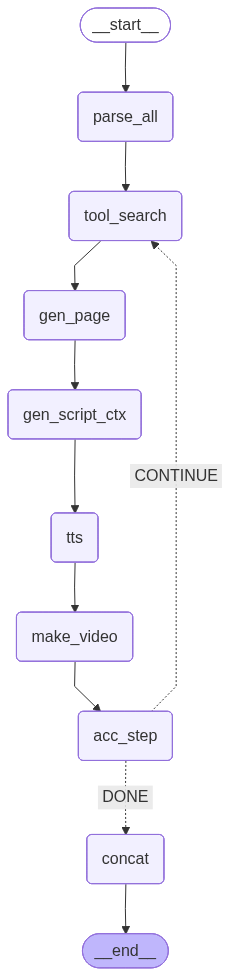

In [260]:
from langgraph.graph import StateGraph, END
builder = StateGraph(State)

builder.add_node("parse_ppt", node_parse_all)
builder.add_node("tool_search", node_tool_search)
builder.add_node("generate_page", node_generate_page_content)
builder.add_node("generate_script", node_generate_script_with_context)
builder.add_node("tts_mp3", node_tts)
builder.add_node("make_video", node_make_video)
builder.add_node("acc_step", node_accumulate_and_step)
builder.add_node("concat", node_concat)


builder.set_entry_point("parse_ppt")
builder.add_edge("parse_ppt", "tool_search")
builder.add_edge("tool_search", "generate_page")
builder.add_edge("generate_page", "generate_script")
builder.add_edge("generate_script", "tts_mp3")
builder.add_edge("tts_mp3", "make_video")
builder.add_edge("make_video", "acc_step")
builder.add_conditional_edges("acc_step", router_continue_or_done, {"continue": "generate_script", "done": "concat"})
builder.add_edge("concat", END)

app = builder.compile()

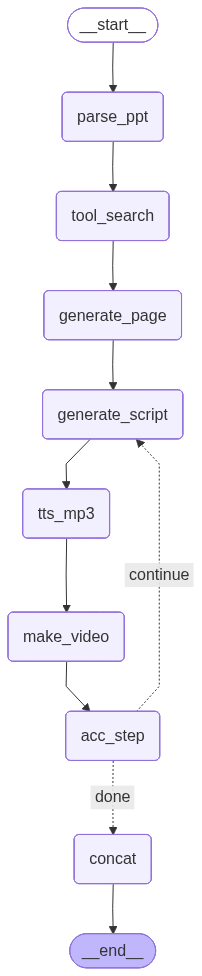

In [261]:
from IPython.display import Image, display

# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

## **4. 시스템 실행**

미션3,4에서 수행한 결과를 통합 테스트 해 봅시다.

### (1) 준비 작업
* 파일 업로드
* 사용자 프롬프트 준비

In [271]:
# 파일 업로드
uploaded = files.upload()
pptx_path = list(uploaded.keys())[0]

Saving sample2_test.pptx to sample2_test (6).pptx


In [272]:
# 사용자 프롬프트
USER_PROMPT = {
    "voice": "alloy",
    "tone": "친절하고 명료한 강의에서 발표톤",
    "style": "예시와 핵심 요점 중심"
}

# 출력 dir 만들기
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### (2) Agent 실행
* State 초기화
* app 실행
    * 실행 시, 잘못된 반복 실행이 발생될 수 있으므로 다음 옵션 적용
        * `app.invoke(state, config={"recursion_limit": 100})`
        * 숫자 100은 조정 가능
* 동영상 play

In [273]:
state = State(
    pptx_path=pptx_path,
    work_dir=OUTPUT_DIR,
    prompt=USER_PROMPT,
    slide_index=0,
    texts=[],
    tables=[],
    images=[],
    slide_image=[],
    page_content=[],
    script="",
    audio="",
    video="",
    all_videos=[]
)

In [274]:
state

{'pptx_path': 'sample2_test (6).pptx',
 'work_dir': 'output',
 'prompt': {'voice': 'alloy',
  'tone': '친절하고 명료한 강의에서 발표톤',
  'style': '예시와 핵심 요점 중심'},
 'slide_index': 0,
 'texts': [],
 'tables': [],
 'images': [],
 'slide_image': [],
 'page_content': [],
 'script': '',
 'audio': '',
 'video': '',
 'all_videos': []}

In [275]:
os.listdir(state["work_dir"])

['slide_02',
 'sample2_test (4).pdf',
 'final_lecture.mp4.txt',
 'sample2.pdf',
 'slide_01',
 'slide_03',
 'slide_05',
 'final_lecture.mp4',
 'slide_2_script.txt',
 'slide_06',
 'AI_04반_07조_1차 수정 (2).pdf',
 'slide_4_script.txt',
 'slide_3_script.txt',
 'AI_04반_07조_1차 수정.pdf',
 'slide_04',
 'slide_1_script.txt',
 'sample2_test (3).pdf',
 'slide_img_1-01.png',
 'slide_07']

In [276]:
# 전체 그래프 실행
result = app.invoke(state, config={"recursion_limit": 100})

# 영상 재생
video_path = result['video']
with open(video_path, "rb") as f:
    data = f.read()
display(Video(data=data, embed=True, mimetype="video/mp4", width=960))

Output hidden; open in https://colab.research.google.com to view.

## **5. Web APP 개발(Gradio)**
* 화면 개발
    * 입력 : ppt파일, 프롬프트(강의 작성톤), voice 선택(alloy, ...)
    * 출력 : 동영상 play, 동영상 다운로드 버튼
* 기본 화면을 제공합니다. 필요한 기능을 직접 추가하세요.

In [277]:
import os
import time
import shutil
import gradio as gr

VOICES = ["alloy", "aria", "verse", "shimmer", "coral", "sage", "tenor", "nova", "amber"]

def run_pipeline_ui(pptx_file, tone, style, voice):
    work_dir = os.path.join("./webio", f"run-{int(time.time())}")
    os.makedirs(work_dir, exist_ok=True)
    pptx_path = os.path.join(work_dir, "input.pptx")
    shutil.copy(pptx_file.name, pptx_path)

    state = {
        "pptx_path": pptx_path,
        "work_dir": work_dir,
        "prompt": {
            "voice": voice or "alloy",
            "tone": tone or "친절하고 명료한 강의 톤",
            "style": style or "예시와 핵심 요점 중심",
        },
        "all_videos": []
    }

    final_state = app.invoke(state, {"recursion_limit": 50000})
    video_path = final_state.get("video")
    return video_path, video_path



# -------------------- Gradio UI --------------------
with gr.Blocks(title="AI 강사 Agent") as demo:

    gr.HTML("""
    <div style="text-align:center; margin-top:20px; margin-bottom:30px;">
        <h1 style="font-size:2.2em;">🎓 AI 강사 Agent</h1>
        <p style="font-size:1.05em;">
            PPT 한 개면 충분합니다! AI가 자동으로 강의 요약, 대본, 음성, 영상을 생성합니다. 🎬
        </p>
    </div>
    """)

    with gr.Row():
        with gr.Column(scale=1, min_width=300):
            gr.HTML("<h3 style='margin-bottom:5px;'>📂 PPTX 파일 업로드</h3>")
            inp_ppt = gr.File(label="PPTX 업로드", file_types=[".pptx"], height=230)

        with gr.Column(scale=2, min_width=350):
            gr.HTML("<h3 style='margin-bottom:5px;'>🎭 말투 & 스타일 설정</h3>")
            inp_tone = gr.Textbox(
                value="친절하고 명료한 강의 톤",
                label="강의 작성 톤 (Tone)",
                placeholder="예: 부드럽고 차분한 교수님 말투",
                lines=2
            )
            inp_style = gr.Textbox(
                value="예시와 핵심 요점 중심",
                label="요약 작성 스타일 (Style)",
                placeholder="예: 핵심 요점 위주로 명확하게",
                lines=2
            )

    gr.HTML("<h3 style='margin-top:25px; margin-bottom:5px;'>🗣️ 음성 톤 설정</h3>")
    inp_voice = gr.Dropdown(
        VOICES, value="alloy", label="TTS Voice (음성 종류)", interactive=True
    )

    with gr.Column(scale=1, min_width=200):
        gr.HTML("<h3 style='margin-bottom:5px;'>🚀 실행</h3>")
        run_btn = gr.Button("▶️ 강의 영상 생성 시작", variant="primary", scale=1)
        gr.HTML("<small>AI가 자동으로 슬라이드별 영상 생성 후 병합합니다.</small>")

    with gr.Row():
        out_video = gr.Video(label="📺 생성된 강의 영상 미리보기", interactive=False)
        out_download = gr.DownloadButton(label="💾 동영상 다운로드")

    gr.Markdown(
        """
        ---
        💡 **Tip**
        - 말투(Tone)는 “따뜻한 설명형”이나 “전문적 발표형”처럼 자유롭게 입력해보세요.
        - 스타일(Style)은 요약문 생성 시 적용되어, 스크립트 내용에 영향을 줍니다.
        """
    )

    run_btn.click(
        run_pipeline_ui,
        [inp_ppt, inp_tone, inp_style, inp_voice],
        [out_video, out_download]
    )

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8469b3914c496c6e65.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
